In [1]:
import scipy.io as sio
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Diagnostic
Les signaux contenus dans le fichier data.npy représentent les mesures d'un accéléromètre posé sur des molettes à découper le verre en mouvement. Certaines sont ébréchées. On souhaiterait détecter lesquelles automatiquement à partir des signaux. 
#### Question : Charger le fichier et observer quelques données.
Les signaux correspondant aux molettes ébréchées comportent des variations brutales répétées. 

Les données ont été échantillonnées à une fréquence de 100 Hz.

**Réponse :**

On récupère le fichier de données. S'agissant de 106 molettes sur 3700 intervalles de temps, on la transpose pour pouvoir accéder plus facilement aux données.

Puis on affiche deux molettes pour avoir une idée de la forme des signaux.

Nombre de molettes   : 106
Intervalles de temps : 3700


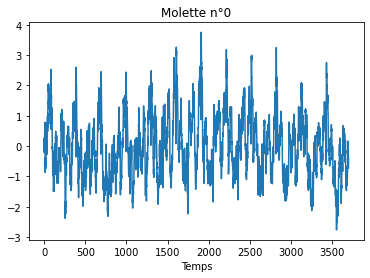

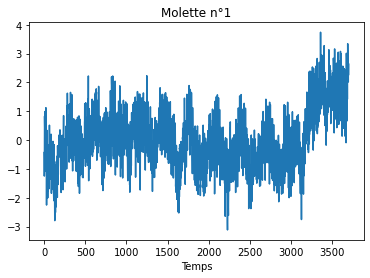

In [2]:
# Chargement du fichier
data = np.load("data.npy")

# Il s'agit de 106 molettes sur 3700 intervalles de temps :
# Les lignes correspondent aux temps, les colonnes au numéro de la molette.
# Pour simplifier les accès aux données, on fait :
data = data.T
print("Nombre de molettes   :", data.shape[0])
print("Intervalles de temps :", data.shape[1])

# Désormais :

#===========================================================================
#->Les lignes correspondent aux numéros de molettes
#->Les colonnes aux temps
#Pour accéder à une molette, faire data[i], où i est le numéro de la molette
#===========================================================================

N = data.shape[1]
t = np.arange(N)

plt.plot(t, data[0])
plt.xlabel("Temps")
plt.title("Molette n°0")
plt.show()

plt.plot(t, data[1])
plt.xlabel("Temps")
plt.title("Molette n°1")
plt.show()

## Filtrage
Comme on dispose ici de tout le signal, on peut utiliser un filtre non causal. 

#### Question : Construire un filtre qui coupe brutalement toutes les fréquences au-delà de 25 Hz en multipliant la TFD du signal par une fenêtre appropriée.   
Attention, les coefficients de la TFD au-delà de la fréquence de Nyquist correspondent aux fréquences négatives !


**Réponse :**
Pour créer le filtre, on doit connaître les relations entre les coefficients de la TFD (calculés par la FFT) et leur fréquence correspondante.

Pour cela, on utilise le fait qu'on soit en situation de zero-padding pour que le $k$e coefficient de la TFD $\tilde{X}_k$ soit lié à la TFTD $X(\Omega)$ de la manière suivante :

$$
\tilde{X}_k = X\left(\frac{2k\pi}{N}\right)
$$

Puis, pour passer de $\dfrac{2k\pi}{N}$ (en radiants par échantillon) aux pulsations (en radiants par seonde), on multiplie par la fréquence d'échantillonnage. Cela nous donne que le $k$e coefficient de la TFD correspond à une fréquence de $\dfrac{kf_e}{N}$.

Maintenant que l'on connaît cette relation, il suffit de couper les fréquences (positives ou négatives) qui sont au-delà de 25Hz.

Pour vérifier que le filtre fonctionne bien, on affiche quelques spectres (zoomés sur une fenêtre autour de 25Hz).

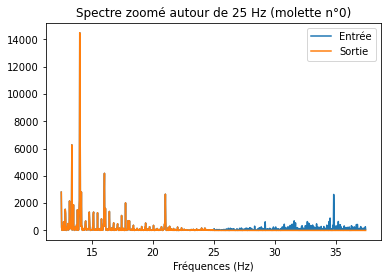

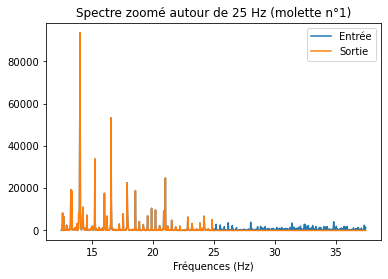

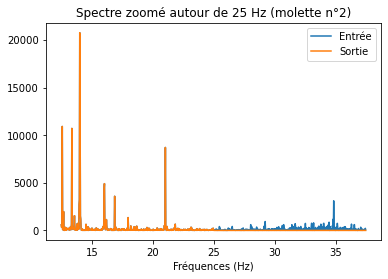

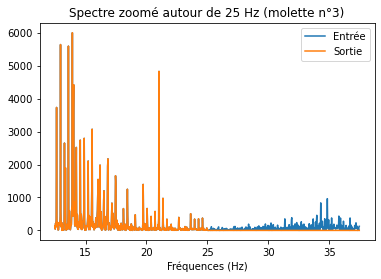

In [3]:
fech = 100

#============================
#Création du filtre passe-bas
#============================

# Fréquences correspondant aux coefficients de la TFD calculés par la FFT
# En effet, le zero-padding permet de passer de la TFD à la TFTD.
# Puis le cours d'échantillonage nous donne le lien entre la TF d'un signal continu et la TFTD du signal échantilloné à fech
freq = fech * (np.arange(N) / N)

# Les fréquences au-dessus de la fréquence de Nyquist sont en fait des fréquences négatives
# freq contient désormais les fréquences : 0-------->fech/2 ---> -fech/2---------->0
freq[freq >= fech/2] = freq[freq >= fech/2] - fech

filtre = abs(freq) < 25

#===============================
#Application du filtre passe-bas
#===============================

# On stocke les données filtrées dans un tableau de mêmes dimensions
data_filtree_frequentiel = np.empty(data.shape,dtype=complex)

for num_echantillon, signal in enumerate(data):
    data_filtree_frequentiel[num_echantillon] = np.fft.fft(signal)*filtre

    
#======================
#Vérification graphique
#======================

# On vérifie que le filtre marche bien en affichant le spectre de quelques signaux
# Pour bien voir la différence, on n'affiche le spectre autour de 25Hz
def comparer_filtrage(num_molette):
    molette_frequentiel = np.fft.fft(data[num_molette])
    plt.plot(freq[N//8:3*N//8], (abs(molette_frequentiel)**2)[N//8:3*N//8], label="Entrée")
    plt.plot(freq[N//8:3*N//8], (abs(data_filtree_frequentiel[num_molette])**2)[N//8:3*N//8], label="Sortie")
    
    titre = "Spectre zoomé autour de 25 Hz (molette n°" + str(num_molette) + ")"
    plt.title(titre)
    plt.xlabel("Fréquences (Hz)")
    plt.legend()

    plt.show()

comparer_filtrage(0)
comparer_filtrage(1)
comparer_filtrage(2)
comparer_filtrage(3)

## Détection de défauts
On a remarqué que la présence de défauts était liée à la quantité d'énergie présente entre 17 Hz et 20 Hz. 

#### Question : Ecrire une fonction permettant de calculer la quantité d'énergie totale d'un signal dans cette bande de fréquence. Utiliser cette fonction pour classer les molettes en deux groupes. 

**Réponse :** on choisit un seuil de 500000 qui fournit 6% de signaux défectueux. On a choisi la convention de calculer l'energie des fréquences, qui, en valeur absolue, sont comprises entre 17Hz et 20Hz. Cela revient juste à multiplier par deux l'énergie des fréquences positives comprises entre ces mêmes valeurs (les signaux sont réels).

In [4]:
def energie(tfd, freq=freq, fmin=17, fmax=20):
    """
    Calcule l'énergie d'un signal entre deux fréquences données.
    Le calcul se fait à partir de la TFD (calculée à partir de la FFT, par exemple).
    Le tableau de fréquences correspondant à chaque coefficient de la TFD est nécessaire pour pouvoir sélectionner les bonnes fréquences à prendre en compte.
    
    Convention : cette méthode prend en compte les énergies des fréquences négatives (les signaux étant réels, cela revient juste à multiplier par deux l'énergie)
    """
    
    energie = 0
    for k in range(len(tfd)):
        if abs(freq[k]) <= fmax and abs(freq[k]) >= fmin:
            energie += abs(tfd[k])**2
    return energie

def classement(dataset=data_filtree_frequentiel, freq=freq, seuil = 500000):
    """
    Classe les données en deux groupes :
    - les données défectueuses où il y a une quantité d'énergie trop importante au-delà du seuil spécifié
    - les autres données
    
    On rappelle en effet qu'une molette défectueuse est une molette qui possède des variations brutales répétées (surplus d'énergie)
    
    dataset est l'ensemble des TFD des signaux.
    freq est le tableau de fréquences
    """
    # Les signaux où l'énergie est au-dessus du seuil sont ceux qui présentent des "variations brutales de fréquences"
    # Ils sont donc défectueux
    data_ok = []
    data_defect = []
    
    for data in dataset:
        if energie(data, freq) >= seuil:
            data_defect.append(data)
        else:
            data_ok.append(data)
            
    return data_ok, data_defect

ok, pasok = classement()

print("Avec ce choix de seuil (seuil=5*10^5), il y a :")
print("==>", len(ok), "signaux non-défectueux")
print("==>", len(pasok), "signaux défectueux")

Avec ce choix de seuil (seuil=5*10^5), il y a :
==> 99 signaux non-défectueux
==> 7 signaux défectueux


# Dérivation numérique
On va étudier ici différentes approches pour calculer la dérivée numérique seconde d'un signal. Le signal 'a_deriver.npy' est échantillonné à une fréquence de 200 Hz.

## Différence finies
On propose, pour commencer, de dériver le signal à l'aide de la formule dite de différences finies suivante

$$y = \frac{x[n] - 2 x[n-1] + x[n-2]}{\Delta t^2}$$

#### Question : Implémenter cette méthode de dérivation et afficher le résultat. Correspond-il à ce à quoi on pourrait s'attendre en regardant le signal d'origine ?





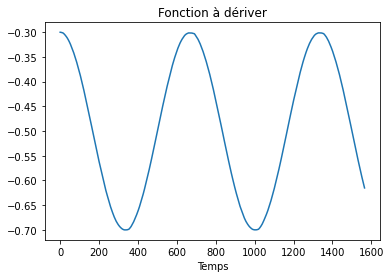

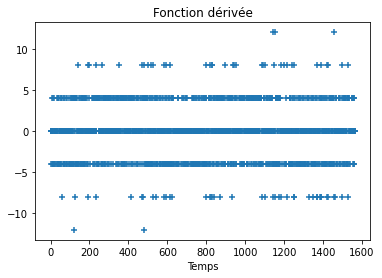

In [5]:
fech = 200

# Chargement du fichier
a_deriver = np.load("a_deriver.npy")

# Affichage de la fonction à dériver
plt.plot(a_deriver)
plt.title("Fonction à dériver")
plt.xlabel("Temps")
plt.show()

def difference_finie(x, dt):
    y = x[2:]-2*x[1:-1]+x[:-2]
    return y/(dt**2)

# Calcul de la dérivée
derivee = difference_finie(a_deriver, 1/fech)

# Affichage de la fonction dérivée
plt.scatter(np.arange(len(derivee)),derivee, marker="+")
plt.title("Fonction dérivée")
plt.xlabel("Temps")
plt.show()

Cela ne correspond pas à ce que l'on pourrait attendre d'un filtre dérivateur. En effet, le signal d'origine a un aspect sinusoïdal : on s'attend donc à ce que la sortie soit elle aussi sinusoïdale.

Cependant, le signal n'est en fait pas sinusoïdal, dans le sens où c'est un échantillonage d'un signal sinusoïdal. Il n'y a donc aucune raison que le signal discret dérivé à l'aide de ce filtre ait la même forme.

#### Question : Afficher le module de la fonction de transfert de ce filtre dérivateur. On pourra, par exemple, calculer la réponse impulsionnelle du filtre, et utiliser le zero padding pour afficher la TFTD évaluée en un grand nombre de points. Quel serait la transformée de Fourier d'un filtre dérivateur continu ? Afficher celle-ci, évaluée aux mêmes fréquences, sur le même graphe. 

On sait que $y[n] = \displaystyle \sum_{k=-\infty}^{+\infty}h[k] \cdot x[n-k]$, où $y$ est la sortie du filtre, $x$ l'entrée et $h$ la réponse impulsionnelle.

En identifiant les coefficients, on trouve **les coefficients de la réponse impulsionnelle**:
* $h[0] = \frac{1}{\Delta t^2}$
* $h[1] = -\frac{2}{\Delta t^2}$
* $h[2] = \frac{1}{\Delta t^2}$
* $h[k] = 0$ sinon

La TFD (calculée à l'aide de la FFT) nous fournit les coefficient de la TFTD (grâce au zero-padding) par la relation déjà évoquée ci-dessus :

$$
\tilde{X}_k = X\left(\frac{2k\pi}{N}\right)
$$

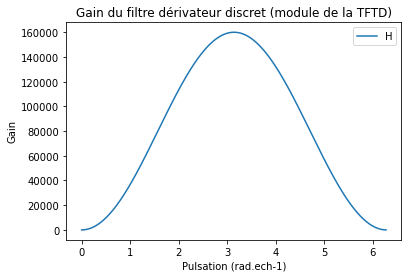

In [6]:
M = 1000
dt = 1/fech

h = np.zeros( M )
h[0] = 1/(dt**2)
h[1] = -2/(dt**2)
h[2] = 1/(dt**2)

tfd = np.fft.fft(h)
rad_ech = 2 * np.pi * np.arange(M)/M

H = abs(tfd)

plt.plot(rad_ech, H, label="H")
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("Gain")
plt.title("Gain du filtre dérivateur discret (module de la TFTD)")
plt.legend()
plt.show()

Pour dériver une fois dans le domaine fréquentiel, il faut "multiplier par $i\omega$". La transformée de Fourier d'un filtre continu, deux fois dérivateur, est donc :

$$
H(\omega) = -\omega^2
$$

La fonction de transfert de ce filtre est exactement cette transformée de Fourier. Affichons désormais les deux fonctions de transfert sur le même graphe :

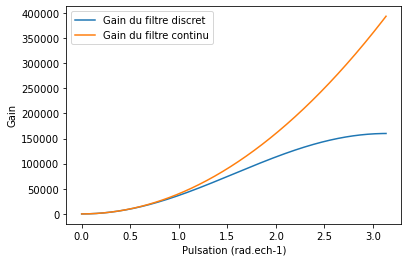

In [7]:
def H_continu(omega):
    return -omega**2

plt.plot(rad_ech[:M//2], H[:M//2], label="Gain du filtre discret")
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("Gain")
plt.plot(rad_ech[:M//2], abs(H_continu(rad_ech/dt))[:M//2], label="Gain du filtre continu")
plt.legend()
plt.show()

## Un FIR : Le filtre de Savitzki-Golay

Le filtre de Saviztki-Golay consiste à calculer les coefficients d'un polynôme interpolant les échantillons sur une fenêtre de taille fixe, puis à dériver ce polynôme et à l'évaluer en un point pour estimer la dérivée au milieu de la fenêtre. 

#### Question : Implémenter ce calcul pour quelques valeurs de la taille de fenêtre et de l'ordre du polynôme (on pourra utiliser toutes les fonctions scipy.signal utiles, les calculs correspondants sont dans le poly). A chaque fois, afficher le signal d'origine et le signal filtré. Si le filtre est implémenté de manière causale, avec quel retard estime-t-on la dérivée ? 




**Réponse** :

On implémente les résultats spécifiés dans le poly (page 44).
Pour cette question, le point où l'on souhaite calculer la dérivée est le point du milieu du signal. Si le filtre est implémenté de manière causale, on peut estimer le retard sur la dérivée en mesurant la phase de la fonction de transfert du filtre.

In [8]:
# Fonction auxiliaire
def poly(coeffs, absc):
    """
    En notant coeffs les coefficients d'un polynôme, retourne le polynôme évalué en les abscisses spécifiés
    Renvoie un tableau numpy de même taille qu'absc.
    
    Les coefficients du polynôme doivent être donnés dans l'ordre croissant de l'ordre.
    """
    p = np.size(coeffs)
    res = np.zeros(np.size(absc))
    for i in range(p):
        res += coeffs[i]*absc**i
    return res

def FIR(x, N_fenetre, deg, afficher=True):
    """
    Applique le filtre au signal x.
    La taille de la fenêtre est N_fenêtre
    Le degré du polynôme à calculer est donné par deg.
    
    Cette fonction affiche le signal filtré comparé au signal non-filtré.
    Cette fonction retourne P'(0), ie la valeur estimée de la dérivée première, suivie du signal interpolé.
    """
    # absc est de taille 2N+1 : -N_fenetre,...0,...N_fenetre
    absc = np.array([k for k in range(-N_fenetre,N_fenetre+1)])
    # la moitié de la taille du signal (donc indice qqonque, pourquoi pas)
    n = np.size(x)//2
    # x tronqué par la fenêtre
    x_tronc = x[n-N_fenetre:n+N_fenetre+1]

    # J est une matrice à 2N_fenetre+1 lignes et à p+1 colonnes (degré du pol + 1)
    # On remplit la matrice J
    J = np.empty( (2*N_fenetre+1,deg+1) )
    for i in range(0,2*N_fenetre+1):
        for j in range(deg+1):
            J[i,j] = (absc[i])**j
    
    # coefficients du polynôme
    a = np.matmul(np.matmul(np.linalg.inv(np.matmul(J.T,J)),J.T), (x_tronc).T)
    
    interp = poly(a, absc)
    
    #Représentation
    if(afficher):
        plt.plot(absc, x_tronc, label = "Signal d'origine")
        plt.plot(absc, interp, label = "Signal interpolé")
        plt.title("Filtre de Savitzki-Golay (N_fenetre=" + str(N_fenetre) + ", deg=" + str(deg) + ")")
        plt.legend()
        plt.show()

    return a[1], interp

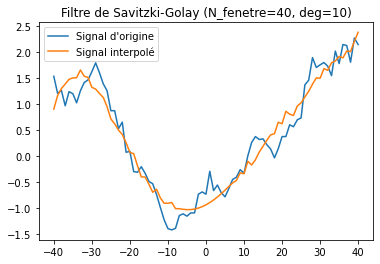

Valeur de la dérivée pour N_fenetre=40, deg=10:  0.03946264359557131


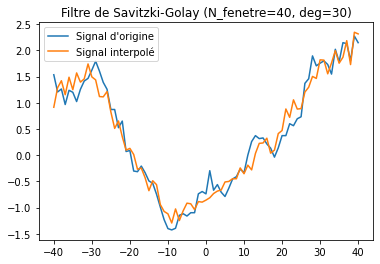

Valeur de la dérivée pour N_fenetre=40, deg=30:  0.04177865347940053


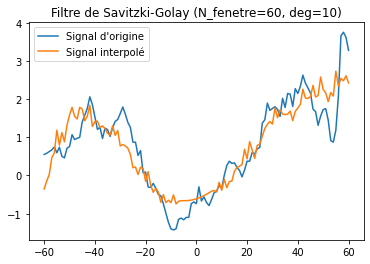

Valeur de la dérivée pour N_fenetre=60, deg=10:  0.02134686762574221


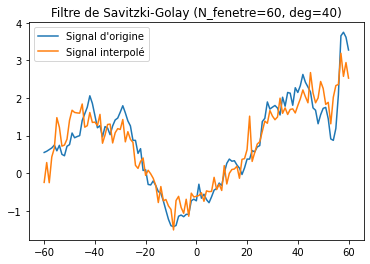

Valeur de la dérivée pour N_fenetre=60, deg=40:  0.01901166670560624


In [9]:
# Affichage
print("Valeur de la dérivée pour N_fenetre=40, deg=10: ", FIR(data[0], 40, 10)[0])
print("Valeur de la dérivée pour N_fenetre=40, deg=30: ", FIR(data[0], 40, 30)[0])

print("Valeur de la dérivée pour N_fenetre=60, deg=10: ", FIR(data[0], 60, 10)[0])
print("Valeur de la dérivée pour N_fenetre=60, deg=40: ", FIR(data[0], 60, 40)[0])

On remarque qu'en général, approximer le signal par un polynôme conserve les basses fréquences, mais estime assez mal les hautes fréquences. On doit augmenter le degré pour essayer d'approximer ces hautes fréquences, mais cela fait apparaître des instabilités (saccadements du signal échantillonné).

#### Question : On souhaite s'assurer que le filtre préserve l'information utile du signal, située en-dessous de 15 Hz. Afficher la fonction de transfert du filtre pour une gamme de valeurs de la taille de fenêtre et de l'ordre du polynôme, et choisir des valeurs appropriées. 

**Réponse :** la fonction de transfert du filtre est la transformée de Fourier de la réponse impulsionnelle. La réponse impulsionnelle se calcule justement en calculant la réponse de ce filtre à une impulsion.

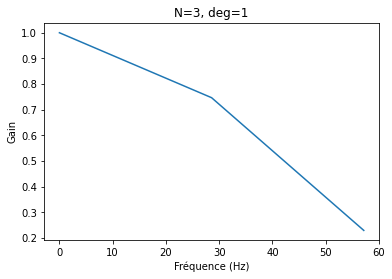

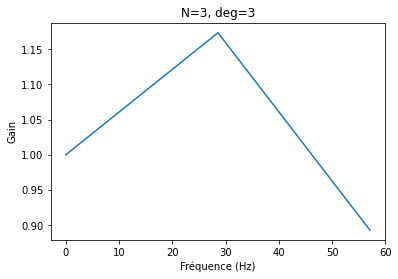

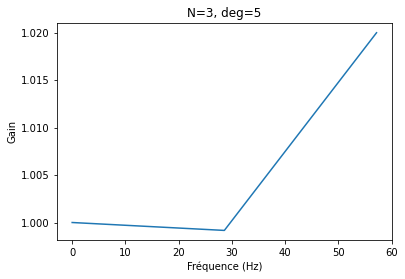

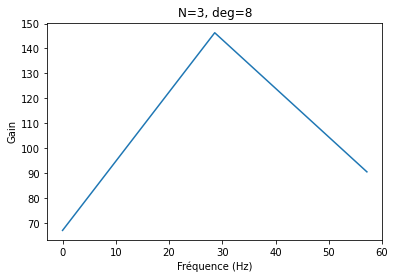

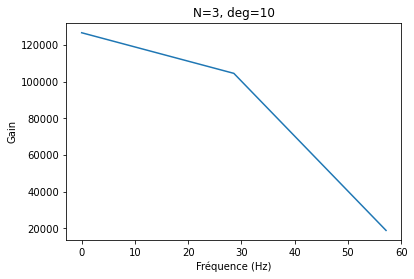

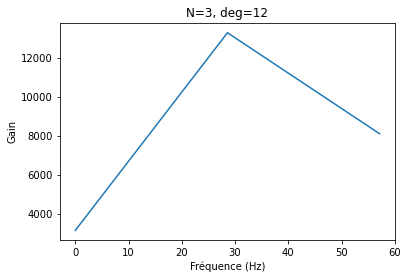

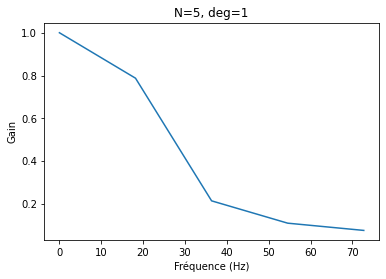

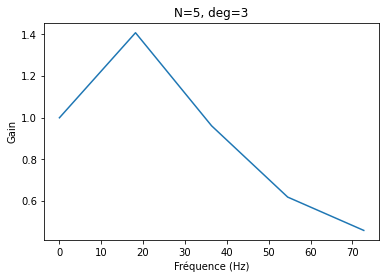

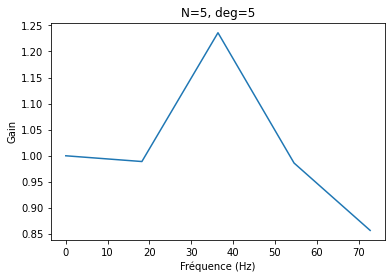

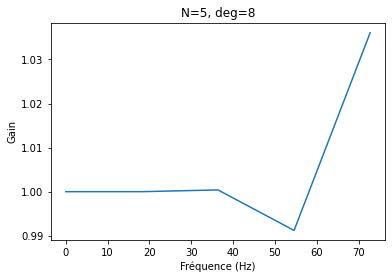

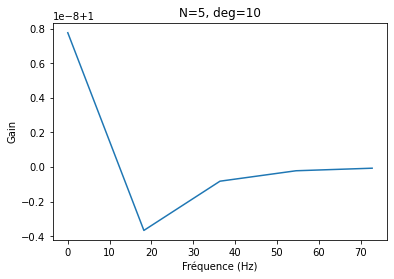

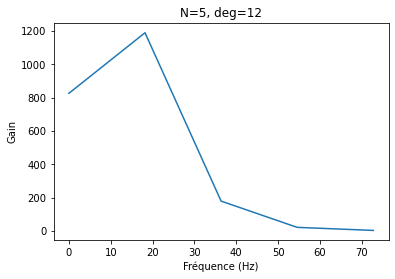

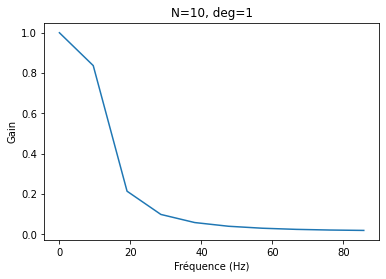

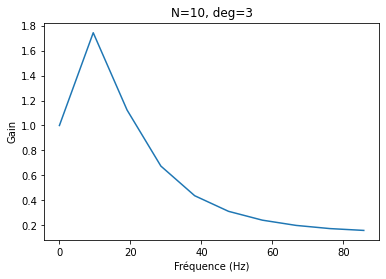

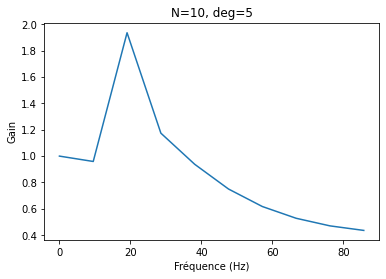

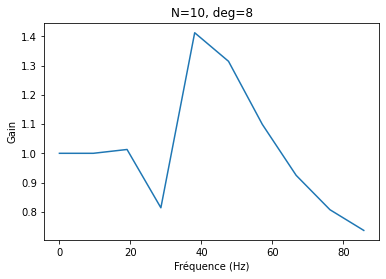

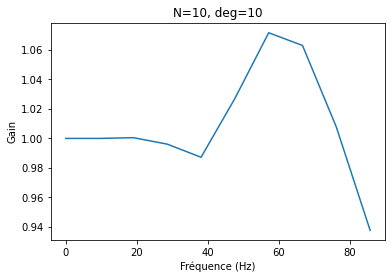

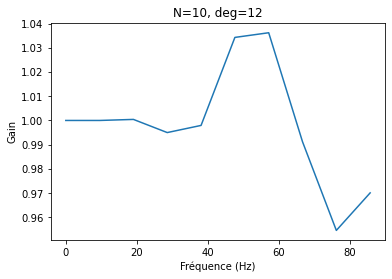

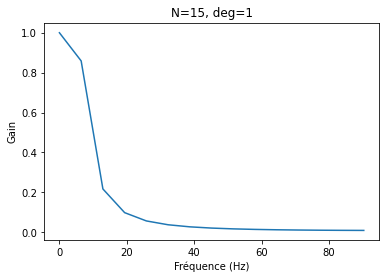

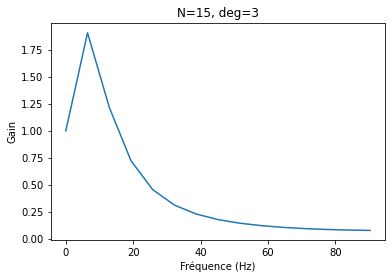

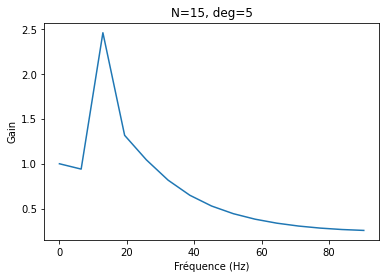

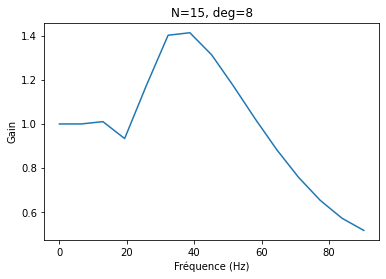

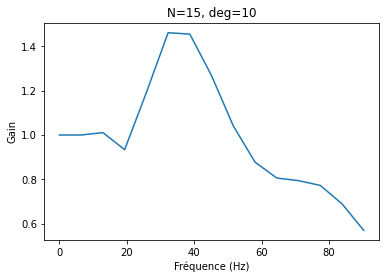

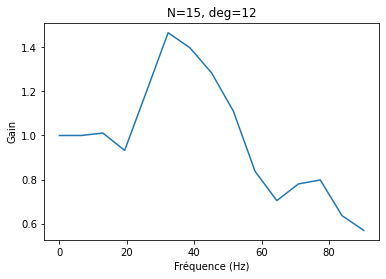

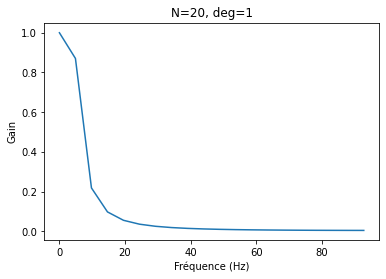

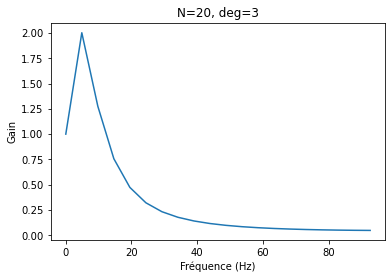

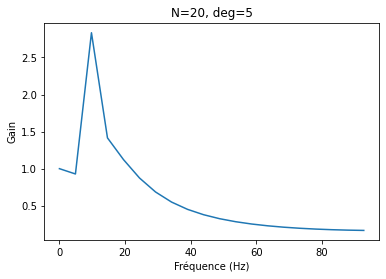

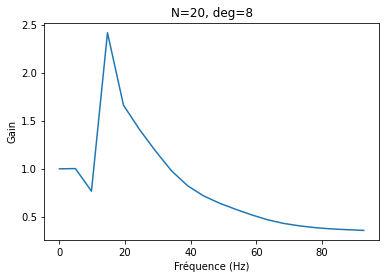

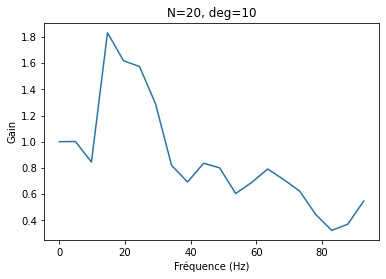

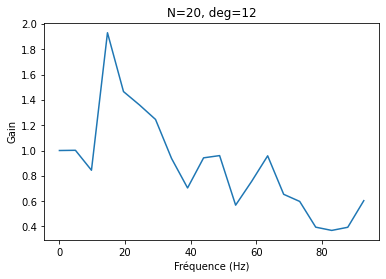

In [10]:
from itertools import product

def reponse_impulsionnelle(N_fenetre, deg):
    impulsion = np.zeros(2*N_fenetre + 1)
    impulsion[0] = 1
    return FIR(impulsion, N_fenetre, deg, afficher=False)[1]

fenetres = [3, 5, 10, 15, 20]
deg = [1, 3, 5, 8, 10, 12]
for N_fenetre, deg in product(fenetres, deg):
    h = np.fft.fft(reponse_impulsionnelle(N_fenetre, deg))
    frequences = fech*np.arange(2*N_fenetre + 1)/(2*N_fenetre + 1)
    plt.plot(frequences[:N_fenetre], (np.abs(h)**2)[:N_fenetre])
    plt.title("N=" + str(N_fenetre) + ", deg=" + str(deg))
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Gain")
    plt.show()

De cette observation, il ressort qu'un certain nombre de choix sont possibles. On retiendra par exemple une taille de fenêtre de 10, et un degré valant 10.

## Un 'observateur'
Une autre solution consiste à modéliser le signal comme la sortie d'un système dynamique. On construit alors un estimateur de la dérivée seconde de la forme
$$
\begin{align}
\dot    x_1 &= x_2 + k_1(x-x_1)\\
\dot    x_2 &= x_3 + k_2(x-x_1)\\
\dot    x_3 &= k_3(x-x_1)
\end{align}
$$
où $k_1$, $k_2$ et $k_3$ sont des paramètres de réglage. L'estimation de la dérivée seconde est alors donnée par $x_3$. 

#### Question : En prenant la transformée de Laplace des équations ci-dessus, donner l'expression de la fonction de transfert entre les $x_i$ et $x$. Montrer qu'il s'agit de trois filtres passe-bas

**Réponse**

Par la suite, on notera :
* $X_i := \mathcal{L}(x_i)$ ;
* $X :=   \mathcal{L}(x)$.

On se place dans les conditions d'Heavyside (conditions initiales nulles). On utilise en particulier, pour passer dans le domaine de Laplace, la linéarité de la transformée.

##### Expressions des filtres

Alors, les transformées de Laplace de ces équations s'écrivent :
$$
\left\{
\begin{array}{rcl}
s X_1(s) &=& X_2(s) + k_1(X(s)-X_1(s))\\
s X_2(s) &=& X_3(s) + k_2(X(s)-X_1(s))\\
s X_3(s) &=& k_3(X(s)-X_1(s))
\end{array}
\right.
$$

Commençons par chercher la transformée du filtre reliant $x_1$ à $x$. Pour cela, on injecte cette relation 
$X_3(s) = \dfrac{k_3}{s}(X(s)-X_1(s))$ (donnée par la troisième équation) dans la deuxième équation, ce qui fournit : $X_2 = \dfrac{k_3}{s^2}(X-X_1) + \dfrac{k_2}{s}(X-X_1)$. Ensuite, on reporte cette expression de $X_2$ dans la première équation.

On obtient donc :
$$
\dfrac{X_1(s)}{X(s)} = H_1(s) = \dfrac{k_3 + sk_2 + s^2k_1}{k_3 + sk_2 + s^2k_1 + s^3}
$$

Puis la première équation donne l'expression de $X_2$ : $X_2 = ((s+k_1)H_1 - k_1)X$, donc $H_2 = (s+k_1)H_1 - k_1$. 

On obtient donc :
$$
\dfrac{X_2(s)}{X(s)} = H_2(s) = \dfrac{sk_3 + s^2k_2}{k_3 + sk_2 + s^2k_1 + s^3}
$$

Enfin, la troisième équation donne l'expression de $X_3$ : $X_3 = \dfrac{1}{s}(k_3 - k_3H_1)X$, donc $H_3 = \dfrac{1}{s}(k_3 - k_3H_1)$.

On obtient donc :
$$
\dfrac{X_3(s)}{X(s)} = H_3(s) = \dfrac{s^2k_3}{k_3 + sk_2 + s^2k_1 + s^3}
$$

##### Etude des filtres

On étudie les limites des gains de ces filtres lorsque $\omega \to 0$ et lorsque $\omega \to +\infty$ (on rappelle que le lien entre la transformée de Fourier et la transformée de Laplace s'écrit $s=i\omega$ dès qu'il y a convergence).

|Fonction de transfert|Limite en 0    |Limite en $+\infty$|
|---------------------|---------------|-------------------|
|$H_1$                |1              |0                  |
|$H_2$                |0              |0                  |
|$H_3$                |0              |0                  |

Le premier filtre est bien un passe-bas et les deux autres sont bien des passe-bande.
Ci-dessous une représentation graphique des gains de ces fonctions de transfert (avec les valeurs numériques ci-dessous) :

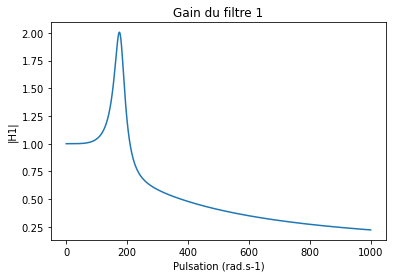

In [11]:
k_1 = 230
k_2 = 21900
k_3 = 8.37*10**6

s = 1j*np.linspace(0, 1000, 1000)

def H1(s):
    return (k_3+k_2*s + k_1*np.power(s,2))/(k_3 + s*k_2 + np.power(s,2)*k_1 + np.power(s,3))

H_1 = H1(s) 
g_H_1 = np.abs(H_1)

plt.plot(s.imag, g_H_1)
plt.xlabel("Pulsation (rad.s-1)")
plt.ylabel("|H1|")
plt.title("Gain du filtre 1")
plt.show()

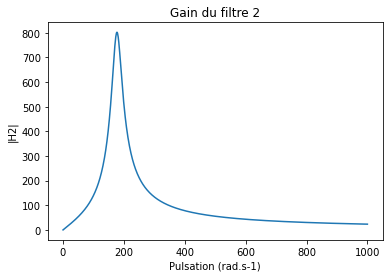

In [12]:
H_2 = np.multiply(s + k_1,H_1) - k_1
g_H_2 = np.abs(H_2)

plt.plot(s.imag, g_H_2)
plt.xlabel("Pulsation (rad.s-1)")
plt.ylabel("|H2|")
plt.title("Gain du filtre 2")

plt.show()

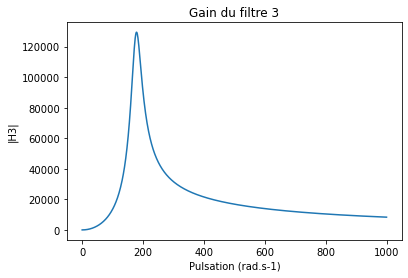

In [13]:
H_3 = np.multiply(s,H_2) + np.multiply(k_2,H_1) - k_2
# c'est une autre expression qui évite une divergence en zéro.
# On rappelle que l'on avait établi que : H_3 = (k_3/s)*(1-H_1)
g_H_3 = np.abs(H_3)

plt.plot(s.imag, g_H_3)
plt.xlabel("Pulsation (rad.s-1)")
plt.ylabel("|H3|")
plt.title("Gain du filtre 3")
plt.show()

Graphiquement, on remarque qu'avec ces valeurs numériques, ces filtres ont une très forte résonnance.

#### Question : On prend $k_1 = 2.30 \times 10^2$, $k_2 = 2.19 \times 10^4$ et $k_3 = 8.37 \times 10^6$. Quelle est la fréquence de coupure des filtres ? Discrétiser le filtre à l'aide de la transformée bilinéaire et implémenter le filtre discret pour calculer les dérivées successives de $x$. 

Fréquence de coupure du premier filtre : $f=39$ Hz.
Pour la trouver, on minimise la distance entre le gain de la fonction de transfert et $\dfrac{1}{\sqrt{2}}$ :

In [14]:
print("Pulsation de coupure (filtre 1):", np.argmin(np.abs(g_H_1 - 0.707)), "rad.s-1")

Pulsation de coupure (filtre 1): 245 rad.s-1


La transformée bilinéaire de Tustin permettant de discrétiser le filtre s'écrit :

$$
s=\frac{2}{\Delta t}\frac{1-z^{-1}}{1+z^{-1}}
$$

La fonction de transfert du filtre discret $H_d(z)$ vérifie donc :

$$
H_d(z) = H(\frac{2}{\Delta t}\frac{1-z^{-1}}{1+z^{-1}})
$$

On note $n = 1-z^{-1}$ et $m=1+z^{-1}$.

Les fonctions de transfert des trois filtres deviennent donc :
- $H_{1d} = H_1(\frac{2}{\Delta t}\frac{n}{m})$
- $H_{3d} = \frac{1}{s}k_3(1-H_{1d})=\frac{\Delta t}{2}\times \frac{m}{n}k_3(1-H_{1d})$
- ??$H_{2d}=\frac{1}{s}H_{3d}+\frac{1}{s}k_2(1-H_{1d})=\frac{\Delta t}{2}\times \frac{z+1}{z-1}(1-H_{1d})(\frac{\Delta t}{2}\times \frac{z+1}{z-1} k_3+k_2)$
- $H_{2d}=(s+k_1)H_{1d}-k_1=(\frac{2}{\Delta t}\times \frac{n}{m} + k_1)H_{1d}-k_1$

In [15]:
def get_s_from_z(z):
    n = 1-1/z
    m = 1+1/z
    return (2/dt)*(n/m)

In [16]:
def H1_discret(z):
    return H1(get_s_from_z(z))

In [17]:
def H2_discret(z):
    s = get_s_from_z(z)
    return (s+k_1) * H1_discret(z)-k_1

In [18]:
def H3_discret(z):
    s = get_s_from_z(z)
    np.multiply(s,H_2) + np.multiply(k_2,H_1) - k_2
    return s*H2_discret(z) + k_2*H1_discret(z) - k_2
    # return (k_3/s)*(1-H1_discret(z))

On vérifie que les diagrammes de gain et de phase restent fidèles à la représentation continue :

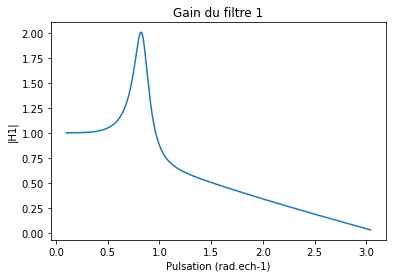

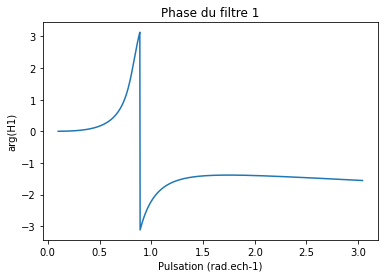

In [19]:
from math import ceil

dt = 1/fech

Omegas = np.linspace(0.1, np.pi - 0.1, 1000)
z = np.exp(1j * Omegas)

H1_d = H1_discret(z)

plt.plot(Omegas, np.abs(H1_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("|H1|")
plt.title("Gain du filtre 1")
plt.show()

#Phase
plt.plot(Omegas, np.angle(H1_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("arg(H1)")
plt.title("Phase du filtre 1")
plt.show()

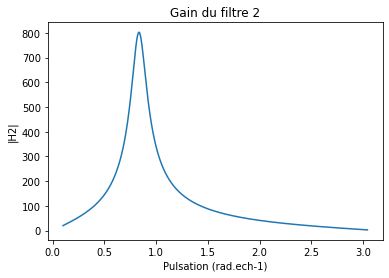

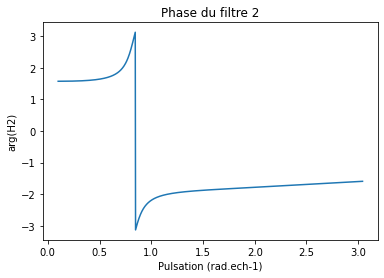

In [20]:
H2_d = H2_discret(z)

plt.plot(Omegas, np.abs(H2_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("|H2|")
plt.title("Gain du filtre 2")
plt.show()

#Phase
plt.plot(Omegas, np.angle(H2_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("arg(H2)")
plt.title("Phase du filtre 2")
plt.show()

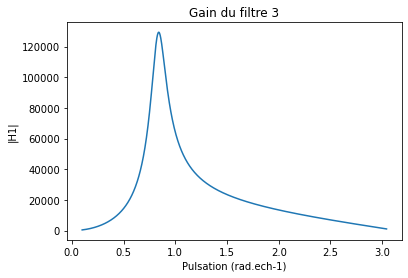

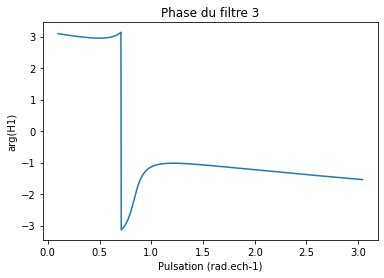

In [21]:
H3_d = H3_discret(z)

plt.plot(Omegas, np.abs(H3_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("|H1|")
plt.title("Gain du filtre 3")
plt.show()

#Phase
plt.plot(Omegas, np.angle(H3_d))
plt.xlabel("Pulsation (rad.ech-1)")
plt.ylabel("arg(H1)")
plt.title("Phase du filtre 3")
plt.show()

#### Question : Comparer et afficher le module et la phase des fonctions de transferts des trois filtres dérivateurs. 

On rappelle que l'on est amenés à comparer trois filtres dérivateurs.
Pour des raisons de lisibilité, le filtre FIR est affiché sur des graphiques distincts.

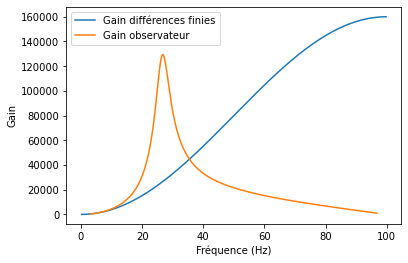

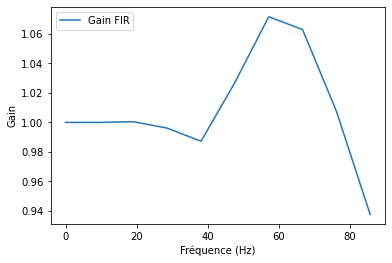

In [22]:
#Gains

plt.plot(fech*rad_ech[1:M//2]/(2*np.pi), H[1:M//2], label="Gain différences finies")
plt.plot(fech*Omegas/(2*np.pi), np.abs(H3_d), label="Gain observateur")


plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain")
plt.legend()
plt.show()

h = np.fft.fft(reponse_impulsionnelle(10, 10))
frequences = fech*np.arange(2*10 + 1)/(2*10 + 1)
plt.plot(frequences[:10], (np.abs(h)**2)[:10], label="Gain FIR")

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain")
plt.legend()
plt.show()

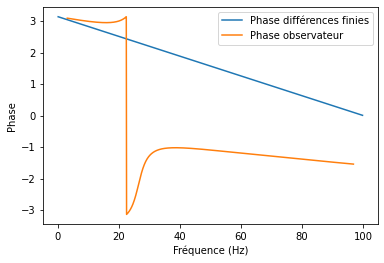

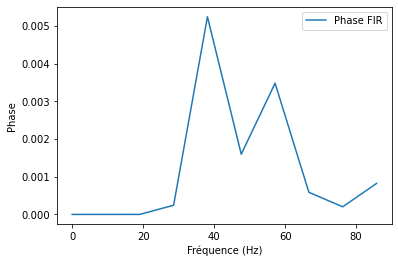

In [23]:
#Phases

plt.plot(fech*rad_ech[1:M//2]/(2*np.pi), (np.angle(tfd))[1:M//2], label="Phase différences finies")
plt.plot(fech*Omegas/(2*np.pi), np.angle(H3_d), label="Phase observateur")


plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase")
plt.legend()
plt.show()

h = np.fft.fft(reponse_impulsionnelle(10, 10))
frequences = fech*np.arange(2*10 + 1)/(2*10 + 1)
plt.plot(frequences[:10], (np.angle(h)**2)[:10], label="Phase FIR")

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase")
plt.legend()
plt.show()

Ces trois filtres ont des gains semblables, dans le sens où ils préservent les basses fréquences. A partir de 15Hz environ, chacun évolue différemment :
* le FIR et l'observateur présentent une résonance et sont ensuite des filtres coupe-haut.
* le filtre à différences finies et au contraire un multiplicateur de hautes fréquences.

On préfèrera donc ne pas utiliser le filtre à différences finies si notre signal présente de fortes variations (elles seront multipliées par le filtre).

En ce qui concerne la phase, aucun ne la laisse intacte. Le FIR a l'avantage d'avoir une phase proche de zéro (avec une petite résonance). Le filtre à différences finies et l'observateur ont au contraire une phase globalement décroissante. Tous ces filtres ont néanmoins le point commun d'avoir une phase positive (ou nulle) : le signal de sortie est donc en avance sur le signal d'entrée, ils ne sont pas réalisables "en direct" dans la pratique (il faut connaître l'entièreté du signal pour l'appliquer). Cela n'est pas cependant pas gênant lorsque l'on sait que l'on analyse des signaux de molettes pré-enregistrés.